## Human classification convulution learning

###checking if using GPU

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Tue Jan 25 19:52:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [55]:
train_dir = "/content/drive/MyDrive/human_detection_project/Database/human_detection_dataset"

BATCH_SIZE = 16
IMG_SIZE = (256, 256)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            )


# validation_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
#                                                             shuffle=True,
#                                                             batch_size=BATCH_SIZE,
#                                                             image_size=IMG_SIZE,
#                                                             validation_split=0.3,
#                                                             subset="validation",
#                                                             seed=234
#                                                             )

Found 571 files belonging to 2 classes.


In [10]:
# for i in range(1, 19):
#   for images, labels in train_dataset.take(i):
#     counter = 0
#     for img in images:
#       counter += 1
#   print(counter)

In [18]:
class_names = train_dataset.class_names

class_names

['human', 'non_human']

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [56]:
# build validation
train_batches = tf.data.experimental.cardinality(train_dataset)
validation_dataset = train_dataset.take(train_batches // 5)
train_dataset = train_dataset.skip(train_batches // 5)

# build test
validation_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_batches // 2)
validation_dataset = validation_dataset.skip(validation_batches // 2)

In [57]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 29
Number of validation batches: 4
Number of test batches: 3


In [58]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [59]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

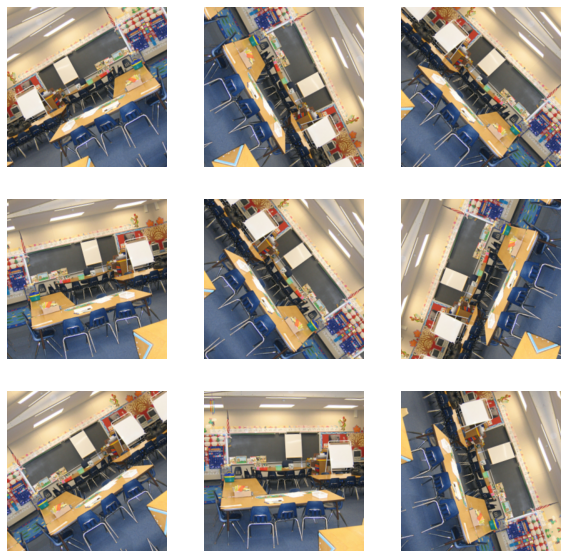

In [60]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

##normalization

In [61]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) same shit

##create the base model

In [62]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [63]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([16, 8, 8, 1280])

In [64]:
# we dont train the base model because the base model is already pre-trained on the "imagenet" dataset
base_model.trainable = False

In [65]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

##layers

In [66]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [67]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

# in the end the result will give me 1 or 0 (shape 1)

(16, 1)


##Build Model

In [68]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [69]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [70]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                           

In [71]:
len(model.trainable_variables)

2

##evaluate without learning

In [79]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(test_dataset)

3/3 [==============================] - 1s 133ms/step - loss: 0.3383 - accuracy: 0.8958


In [80]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.34
initial accuracy: 0.90


##training

In [81]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

# history = model.fit(train_dataset,
#                     epochs=30,)

Epoch 1/20
29/29 [==============================] - 6s 164ms/step - loss: 0.3632 - accuracy: 0.8475 - val_loss: 0.3924 - val_accuracy: 0.8281
Epoch 2/20
29/29 [==============================] - 6s 162ms/step - loss: 0.3902 - accuracy: 0.8322 - val_loss: 0.4302 - val_accuracy: 0.8594
Epoch 3/20
29/29 [==============================] - 6s 162ms/step - loss: 0.3664 - accuracy: 0.8301 - val_loss: 0.3120 - val_accuracy: 0.8906
Epoch 4/20
29/29 [==============================] - 6s 164ms/step - loss: 0.3714 - accuracy: 0.8344 - val_loss: 0.3979 - val_accuracy: 0.8750
Epoch 5/20
29/29 [==============================] - 6s 162ms/step - loss: 0.3808 - accuracy: 0.8214 - val_loss: 0.3065 - val_accuracy: 0.9062
Epoch 6/20
29/29 [==============================] - 6s 162ms/step - loss: 0.3638 - accuracy: 0.8388 - val_loss: 0.4002 - val_accuracy: 0.8281
Epoch 7/20
29/29 [==============================] - 6s 163ms/step - loss: 0.3280 - accuracy: 0.8475 - val_loss: 0.3066 - val_accuracy: 0.9531
Epoch 

In [87]:
model.evaluate(test_dataset)

3/3 [==============================] - 1s 134ms/step - loss: 0.3330 - accuracy: 0.8750


[0.3330059349536896, 0.875]

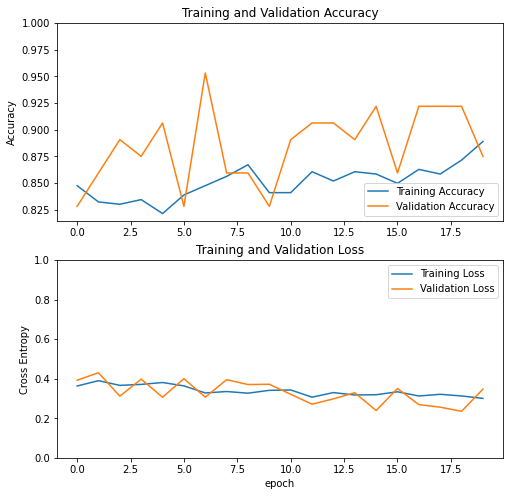

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##Fine tuning



In [88]:
base_model.trainable = True

In [89]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [90]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [91]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                           

In [92]:
len(model.trainable_variables)

56

In [94]:
fine_tune_epochs = 10
initial_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/30
29/29 [==============================] - 7s 167ms/step - loss: 0.2832 - accuracy: 0.8715 - val_loss: 0.1594 - val_accuracy: 0.9375
Epoch 21/30
29/29 [==============================] - 7s 169ms/step - loss: 0.2119 - accuracy: 0.9085 - val_loss: 0.1952 - val_accuracy: 0.9531
Epoch 22/30
29/29 [==============================] - 7s 171ms/step - loss: 0.2142 - accuracy: 0.9107 - val_loss: 0.1412 - val_accuracy: 0.9219
Epoch 23/30
29/29 [==============================] - 7s 171ms/step - loss: 0.2095 - accuracy: 0.9259 - val_loss: 0.1752 - val_accuracy: 0.8906
Epoch 24/30
29/29 [==============================] - 7s 169ms/step - loss: 0.1968 - accuracy: 0.9390 - val_loss: 0.0828 - val_accuracy: 0.9844
Epoch 25/30
29/29 [==============================] - 7s 170ms/step - loss: 0.1496 - accuracy: 0.9368 - val_loss: 0.1122 - val_accuracy: 0.9531
Epoch 26/30
29/29 [==============================] - 7s 170ms/step - loss: 0.1579 - accuracy: 0.9346 - val_loss: 0.1245 - val_accuracy: 0.9688

In [95]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

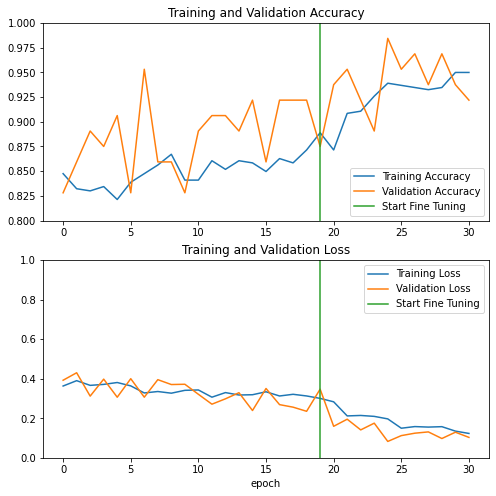

In [96]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [97]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 1s 135ms/step - loss: 0.0746 - accuracy: 0.9792
Test accuracy : 0.9791666865348816


Predictions:
 [1 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1]
Labels:
 [1 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1]


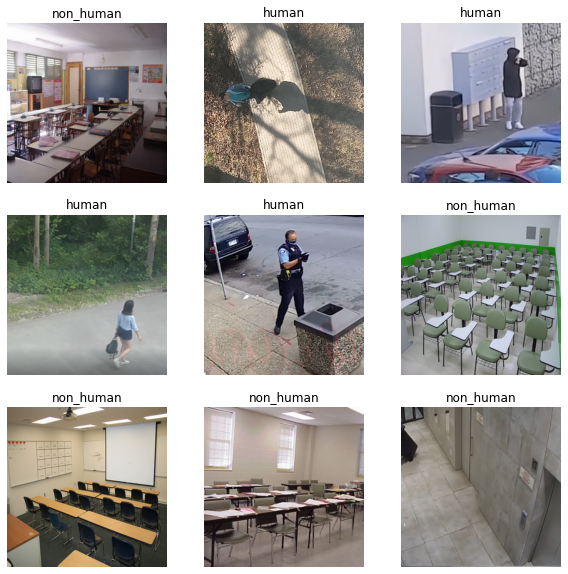

In [99]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [100]:
model.save("/content/drive/MyDrive/human_detection_project/models/transfer_learning_mobileNet.hdf5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
